# Fáza 1 - Prieskumná analýza
AUTORI: MICHAEL JOHN ČVERČKO 40%, FILIP MOJTO 60%
## EDA vizualizácia

- Predtým, ako začneme so samotnou analýzou a jej vizualizáciou, najskôr je potrebné naimportovať si nejaké knižnice.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import scipy.stats as stats
from datetime import datetime
from scipy.stats import levene
from scipy.stats import mannwhitneyu
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy.stats import iqr

### Analýza súborov

- Pracujeme s tromi __.csv__  súbormi, kde jednotlivé atribúty sú oddelené __tabulátormi__. Súbory máme udržované v nasledovnej štruktúre:

  - EDA.ipynb
  - resources/
    * user.csv
    * product.csv
    * session.csv
- Daná štruktúra predstavuje __hierarchické usporiadanie__ súborov v našom projektovom adresári. Teraz si môžeme vytvoriť konštantné premenné
  predstavujúce relatívne cesty pre neskoršiu manipuláciu so súbormi:

In [4]:
PRODUCT_FILE_PATH = "resources/product.csv"
USER_FILE_PATH = "resources/user.csv"
SESSION_FILE_PATH = "resources/session.csv"

#### Vzťahy medzi súbormi
- Máme celkovo 3 dátové súbory. Keď sa pozrieme na vzťah medzi jedným používateľom a produktom, tak možno usúdiť, že ide o vzťah typu
  __many-to-many__, nakoľko jeden používateľ môže (ne)kúpiť 0 a viac produktov a jeden produkt môže byť viazaný s viacerými používateľmi, ktorí si ho
  nekúpili. Je preto nutné vytvoriť spojovací súbor, ktorý bude obsahovať záznamy s referenciami na užívateľov aj na produkty. To predstavuje práve súbor session.csv, ktorý okrem product_ean a user_id obsahuje aj údaje o interakcii užívateľa s konkrétnym produktom.

### Analýza záznamov

- Jednotlivé záznamy sú uchovávané v .csv súboroch a oddelovač atribútov je tabulátor. Jeden riadok bude teda predstavovať jeden záznam a hodnoty oddelené tabulátorom budú hodnoty pre konkrétny atribút (stĺpec). Pre zistenie počtu záznamov potrebujeme najskôr každý súbor otvoriť a získať tak aj premennú pre dataset:

In [5]:
df_pro = pd.read_csv(PRODUCT_FILE_PATH, delimiter='\t')
df_usr = pd.read_csv(USER_FILE_PATH, delimiter='\t')
df_sess = pd.read_csv(SESSION_FILE_PATH, delimiter='\t')

- Mnohé atribúty obsahujú nešpecifikované hodnoty (NaN), preto sme sa rozhodli tieto hodnoty nahradiť:

  a) __Priemerom__, ak je daná hodnota numerická, inak
  
  b) __Modusom__ (najčastejšie sa vyskytujúca hodnota)

  c) __unspecified__ v prípade distribučných grafov

- Teraz možno jednoducho použiť funkciu len() a vypísať dĺžky všetkých datasetov:

In [6]:
df_pro_len = len(df_pro)
df_usr_len = len(df_usr)
df_sess_len = len(df_sess)

print(f'Počet produktov: {df_pro_len}')
print(f'Počet používateľov: {df_usr_len}')
print(f'Počet interakcií: {df_sess_len}')

Počet produktov: 14967
Počet používateľov: 2533
Počet interakcií: 11099


- Na zistenie počtu a typov atribútov môžeme využiť nasledovné funkcie:

In [7]:
print(f'Number of attributes for product.csv: {df_pro.shape[1]}')
print(f'Number of attributes for user.csv: {df_usr.shape[1]}')
print(f'Number of attributes for session.csv: {df_sess.shape[1]}')

Number of attributes for product.csv: 4
Number of attributes for user.csv: 11
Number of attributes for session.csv: 25


In [8]:
df_pro.dtypes

location       object
product_ean     int64
store_name     object
code           object
dtype: object

In [9]:
df_usr.dtypes

address             object
name                object
race                object
registration        object
username            object
current_location    object
sex                 object
birthdate           object
mail                object
user_id              int64
job                 object
dtype: object

In [10]:
df_sess.dtypes

browser_name                       object
pct_input                         float64
wild_mouse_duration               float64
pct_scroll_move_duration          float64
pct_wild_mouse                    float64
session_start                      object
pct_doubleclick                   float64
pct_rage_click                    float64
pct_click                         float64
page_activity_duration            float64
product_ean                         int64
pct_scrandom                      float64
mouse_move_total_rel_distance     float64
pct_click_product_info            float64
scroll_move_total_rel_distance    float64
session_id                          int64
pct_mouse_click                   float64
pct_scroll_move                   float64
user_id                             int64
screen_width                       object
session_duration                  float64
screen_height                      object
total_load_time                   float64
ack                               

### Analýza atribútov
- Teraz analyzujeme niektoré významné atribúty a ukážeme ich distribúcie a iné deskriptívne štatistiky. Nato využijeme funkciu _describe()_.
- Nešpecifikované hodnoty v tomto prípade pre prehľadnosť nahradíme labelom _unspecified_.


#### Analýza pohlaví

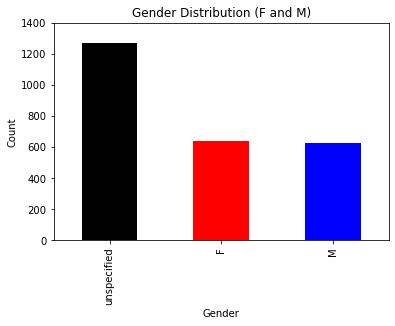

count            2533
unique              3
top       unspecified
freq             1266
Name: sex, dtype: object

In [11]:
gender_df = df_usr['sex']

gender_df.fillna("unspecified", inplace=True)
gender_counts = gender_df.value_counts()

gender_counts.plot(kind='bar', color=['black', 'red', 'blue'], alpha=1)
plt.ylim(0, 1400)
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Gender Distribution (F and M)')
plt.show()

gender_df.describe()

- Z poskytnutých deskriptívnych štatistík vidno celkový počet elementov v datasete, a aj to, že sa zrejme pôjde o kategórie, nakoľko unikátne hodnoty sú len 2. Aj graf, aj štatistika ukazuje, že medzi používateľmi o čosi prevažujú ženy. 

#### Analýza top 30 lokácií produktov
- V tejto časti analyzujeme distribúcie krajín, s ktorými sú spojené dané produkty. Pre prehľadnosť sme sa rozhodli obmedziť výsledky len na top 30 krajín.

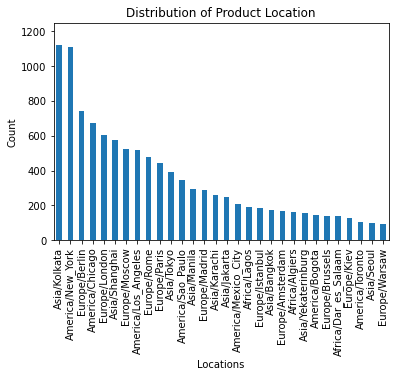

count            14967
unique             184
top       Asia/Kolkata
freq              1121
Name: location, dtype: object

In [13]:
loc_df = df_pro['location']
loc_df.fillna("unspecified", inplace=True)
loc_counts = loc_df.value_counts().head(30)

loc_counts.plot(kind='bar', alpha=1)
plt.ylim(0, 1250)
plt.xlabel('Locations')
plt.ylabel('Count')
plt.title('Distribution of Product Location')
plt.show()

loc_df.describe()

- Z štatistík možno vidieť opäť celkový počet produktov pochádzajúcich z top 30 krajín. Opäť možno aj z grafu vidieť, že najväčším nákupným mestom je Kolkata.

#### Analýza distribúcie webových prehliadačov
- Pomocou Pie Chartu v tejto časti analyzujeme distribúciu webových prehliadačov používaných počas sedení. Celkovo sme v datasete zaznamenali niekoľko typov prehliadačov.

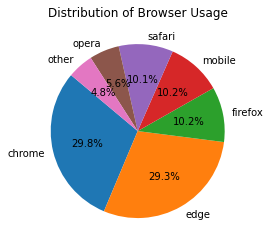

count      11099
unique         7
top       chrome
freq        3304
Name: browser_name, dtype: object

In [14]:
brow_df = df_sess['browser_name']
brow_df.fillna("unspecified", inplace=True)

brow_counts = brow_df.value_counts().head(25)
brow_counts

plt.pie(brow_counts, labels=brow_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Categories')


plt.title('Distribution of Browser Usage')
plt.show()

brow_df.describe()

- V štatistike vidno počet zaznamenaných sedení. Počas nich bolo použitých celkovo 7 webových prehliadačov, z ktorých boli najpopulárnejší chrome a edge, ktoré tvoria takmer 60 percent celkovej používanosti.

#### Analýza distribúcie veku
- V tejto časti skúmame distribúciu veku jednotlivých používateľov. Nakoľko máme prístupnú iba hodnotu 'birthdate', museli sme tento atribút najskôr prekonvertovať na požadovaný formát a následne odčítať od súčasného času. Na záver sme výslednú hodnotu museli ešte premeniť z dní na roky.


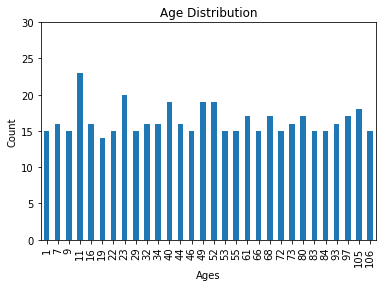

count    1393.000000
mean       56.956927
std        33.090496
min         0.000000
25%        29.000000
50%        56.000000
75%        84.000000
max       116.000000
Name: age, dtype: float64

In [16]:
df_ages = pd.DataFrame({'user_id' : df_usr['user_id'],
                'age': (datetime.now() - pd.to_datetime(df_usr['birthdate'], format='%Y-%m-%d'))
                .apply(lambda x: x.days // 365) }).dropna(how='any')


age_counts = df_ages['age'].value_counts().head(30).sort_index()
age_counts.index = age_counts.index.astype(int)

age_counts.plot(kind='bar', alpha=1)
plt.ylim(0, 30)
plt.xlabel('Ages')
plt.ylabel('Count')
plt.title('Age Distribution')
plt.show()

df_ages['age'].describe()

- Z dostupnej štatistiky možno vidieť, že priemerný vek užívateľa na pohybuje na úrovni 56 rokov. Od tejto hodnoty sú všetky hodnoty odchýlené v hodnote 33. Najmenší vek užívateľa nie je ani rok a najstarší vek 116 rokov. Ešte možno pozorovať, aké percento užívateľov je mladších ako uvedené roky, napríklad 1/4 užívateľov je starších ako 84 rokov.

#### Analýza aktivity užívateľov na stránkach
- V tejto časti skúmame aktivitu používateľov na stránkach z hľadiska veku. Využívame pritom predchádzajúci dataset, ktorý obsahuje user_id a vypočítaný vek na základe dátumu narodenia.

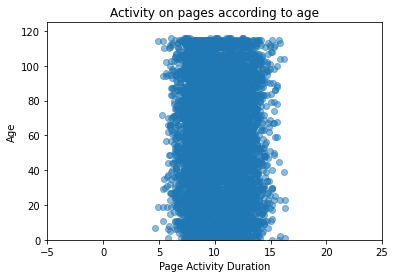

count    6030.000000
mean       10.226932
std         2.119439
min         4.651370
25%         8.470945
50%        10.043925
75%        11.968680
max        16.280780
Name: page_activity_duration, dtype: float64

In [17]:
page_time_subset = df_sess[['user_id', 'page_activity_duration']]
merged_df = df_ages.merge(page_time_subset, on='user_id', how='inner')

plt.scatter(merged_df['page_activity_duration'], merged_df['age'], alpha=0.5)
plt.xlabel('Page Activity Duration')
plt.ylabel('Age')
plt.title('Activity on pages according to age')

plt.xlim(-5, 25)
plt.ylim(0, 125)

plt.show()

merged_df['page_activity_duration'].describe()

- Z uvedenej štatistiky vidno počet sedení, ktorých užívatelia mali špecifikované miesto narodenia, ID a bola nameraný strávený čas na stránke. Priemer času stráveného na stránke bol niečo cez 10 minút. Hodnoty sú od tejto hodnoty odchýlené v priemere o 2 minúty. Minimálny nameraný čas na stránke bol okolo 4 aj pol minúty, najväčší až niečo cez 16. Ďalej možno napríklad vidieť, že 50 percent užívateľov trávi na stránke menej ako 10 minút času.

#### Analýza dĺžky pohybu myši užívateľov
- V tejto časti sa venujeme analýze dĺžky pohybu myši pri jednotlivých užívateľoch.

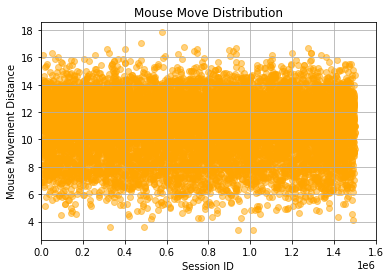

count    11088.000000
mean        10.977960
std          2.125200
min          3.388300
25%          9.621833
50%         11.281175
75%         12.496550
max         17.831800
Name: mouse_move_total_rel_distance, dtype: float64

In [18]:
mouse_mv_df = df_sess[['mouse_move_total_rel_distance', 'session_id']]

plt.scatter(mouse_mv_df['session_id'], mouse_mv_df['mouse_move_total_rel_distance'], alpha=0.5, color='Orange')
plt.xlabel('Session ID')
plt.ylabel('Mouse Movement Distance')
plt.title('Mouse Move Distribution')


plt.xlim(0, 1600000)
plt.grid(True)
plt.show()
mouse_mv_df['mouse_move_total_rel_distance'].describe()


#### Analýza distribúcie výsledkov sedení



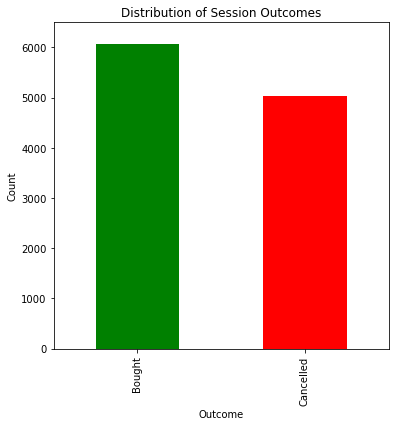

count    11099.000000
mean         0.547347
std          0.497776
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: ack, dtype: float64

In [19]:
ack_df = df_sess['ack']
ack_counts = ack_df.value_counts()

plt.figure(figsize=(6, 6))  
ack_counts.plot(kind='bar', color=['green', 'red'], alpha=1)

plt.xticks(range(len(['Bought', 'Cancelled'])), ['Bought', 'Cancelled'])
plt.ylim(0, 6500)
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.title('Distribution of Session Outcomes')

plt.show()

ack_df.describe()

#### Analýza kompletného času načítavania počas sedení

count    11099.000000
mean         4.009680
std          2.848359
min          0.029800
25%          1.944085
50%          3.355530
75%          5.361660
max         21.149270
Name: total_load_time, dtype: float64

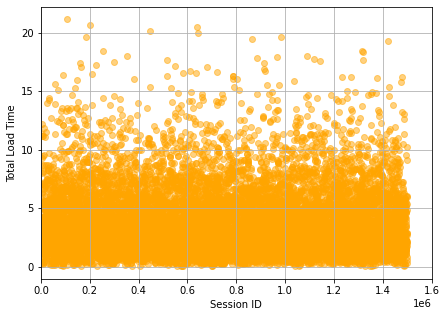

In [20]:
load_time_df = df_sess[['total_load_time', 'session_id']]

plt.figure(figsize=(7, 5))
plt.scatter(load_time_df['session_id'], load_time_df['total_load_time'], alpha=0.5, color='Orange')
plt.xlabel('Session ID')
plt.ylabel('Total Load Time')
plt.xlim(0, 1600000)
plt.grid(True)

load_time_df['total_load_time'].describe()

#### Analýza počtu sedení za mesiac v roku 2022

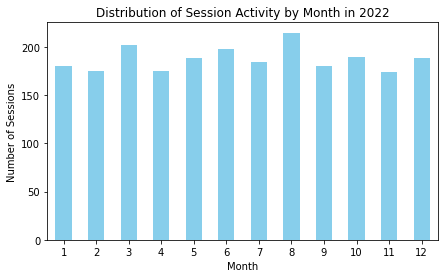

In [21]:
# Assuming 'df_sess' is your DataFrame
df_sess['session_start'] = pd.to_datetime(df_sess['session_start'], format='%Y-%m-%d %H:%M:%S')


df_sess_2021_c = pd.DataFrame({
    "start": df_sess[df_sess['session_start'].dt.year == 2022]['session_start'].dt.month
})
                              
df_sess_2021_c
#Group by month and count the number of sessions
session_count_by_month = df_sess_2021_c.groupby('start').size()
session_count_by_month


# Create a plot
plt.figure(figsize=(7, 4))
session_count_by_month.plot(kind='bar', color='skyblue')
plt.xlabel('Month')
plt.ylabel('Number of Sessions')
plt.title('Distribution of Session Activity by Month in 2022')
plt.xticks(rotation=0)
plt.show()

#### Analýza rás užívateľov
- Nešpecifikované hodnoty sú v tomto prípade opäť nahradené hodnotou _unspecified_.

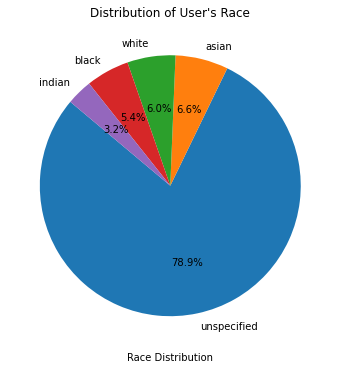

count            2533
unique              5
top       unspecified
freq             1999
Name: race, dtype: object

In [22]:
race_df = df_usr['race']
race_df.fillna("unspecified", inplace=True)
race_counts = race_df.value_counts()

plt.figure(figsize=(6, 6))  
plt.pie(race_counts, labels=race_counts.index, autopct='%1.1f%%', startangle=140)

plt.xlabel('Race Distribution')
plt.title("Distribution of User's Race")

plt.show()

race_df.describe()

- Z grafu vidno, že najčastejšou špecifikovanou rasou sú aziati.

### Párová analýza
- V tejto časti skúmame závislosti medzi rôznymi dvojicami dát. Zameriavame sa na hľadanie najvýznamnejších:


  a) __Korelácií__
  
  b) __Homogénných rozptylov__
  

- Výsledné štatistiky na záver sprehľadňujeme pomocou rôznych grafov.

#### Korelácie

- V tejto časti využívame funkciu _find_corr()_ na porovnanie všetkých numerických dvojích a nájdenie 3 najvýznamejších korelácií medzi nimi.
- Pre zobrazenie jednotlivých korelácií používate graf _ScatterPlot_, kde takisto zobrazujeme silu tejto závislosti pomocou __regresívnej priamky__.

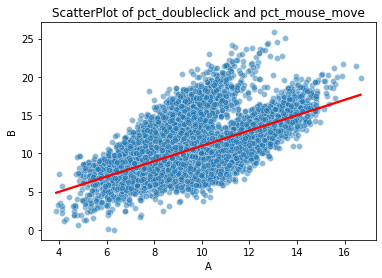

p-value: 0.5922055589951355




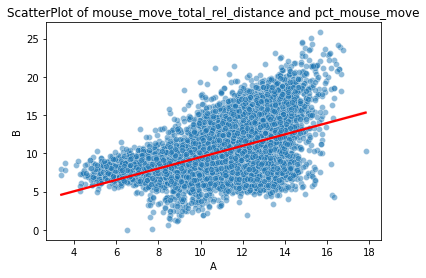

p-value: 0.485381430378118




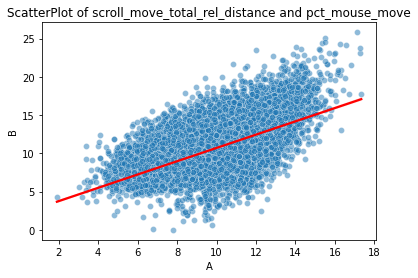

p-value: 0.5816662133668252




In [23]:
def find_corr(df, number=3):
    COLUMN_COUNT = df.shape[1]
    pairs = []
    
    for i in range (0, COLUMN_COUNT):
        col_A_name = df.columns[i]
        col_A = df.iloc[:, i]
        
        for g in range (i + 1, COLUMN_COUNT):
            col_B_name = df.columns[g]
            col_B = df.iloc[:, g]
            
            # Check if the data type of both columns is numeric
            if col_A.dtype in [int, float] and col_B.dtype in [int, float]:
                new_df = pd.DataFrame({'A': col_A, 'B': col_B})

                pearson_corr = new_df['A'].corr(new_df['B'], method='pearson')
                spearman_corr = new_df['A'].corr(new_df['B'], method='spearman')
                kendall_corr = new_df['A'].corr(new_df['B'], method='kendall')
                
                if pearson_corr > 0.05:
                    
                    #This represents a dictionary containing both attributes and their p-value
                    new_el = {
                        'A': col_A_name,
                        'B': col_B_name,
                        'p_value': pearson_corr
                    }
                    
                    if len(pairs) < number:
                        pairs.append(new_el)
                    else:
                        for el in pairs:
                            if el['p_value'] < pearson_corr:
                                pairs.append(new_el)

                                pairs.remove(el)
                                break
    
    return pairs
    
list = find_corr(df_sess)

for el in list:
    new_df = pd.DataFrame({'A': df_sess[el['A']], 'B': df_sess[el['B']]})

    sns.scatterplot(x='A', y='B', data=new_df, alpha=0.5)
    plt.title(f"ScatterPlot of {el['A']} and {el['B']}")

    sns.regplot(x='A', y='B', data=new_df, scatter=False, color='red')
    plt.show()
    
    print(f"p-value: {el['p_value']}")
    print('\n')


- Výsledná analýza ukázala, že najväčšiu koreláciu majú atribúty _pct_doubleclick_ a _pct_mouse_move_.

#### Hľadanie homogénnych rozptylov medzi atribútmi pomocou Levene testu

- Druhý typ párovej závislosti medzi dvomi premennými môže byť rovnaký rozptyl dát. V tomto prípade opäť testujeme všetky kombinácie čiselných dát a hľadáme 3 najviac homogénne dáta. Pre prehľadnosť takisto aplikujeme BoxPlot grafy.
- Nakoľko hľadáme číselné atribúty, nešpecifikované hodnoty v tomto prípade nahradíme __priemerom__.

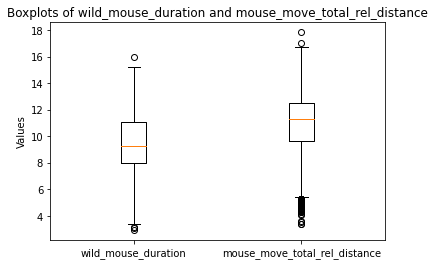

p-value: 0.8345364624962349




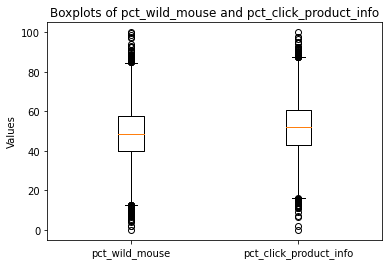

p-value: 0.8206389061035633




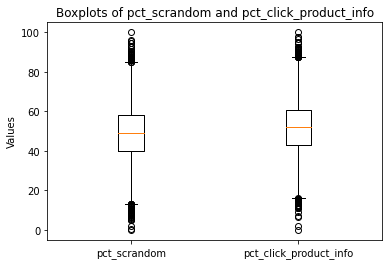

p-value: 0.8247346856788068




In [24]:
# This function tests all combinations of attributes in the dataframe and performs Levene test on them
# and returns the top i pairs with the highest level of homogenous variance
def find_homog_var(df, number=3):
    COLUMN_COUNT = df.shape[1]
    pairs = []
    
    for i in range (0, COLUMN_COUNT):
        col_A_name = df.columns[i]
        col_A = df.iloc[:, i]
        
        for g in range (i + 1, COLUMN_COUNT):
            col_B_name = df.columns[g]
            col_B = df.iloc[:, g]
            
            # Check if the data type of both columns is numeric
            if col_A.dtype in [int, float] and col_B.dtype in [int, float]:
                mean = col_A.mean()
                col_A.fillna(mean, inplace=True)

                mean = col_B.mean()
                col_B.fillna(mean, inplace=True)
                
                new_df = pd.DataFrame({'A': col_A, 'B': col_B})
                
                # Perform the Levene test if data types are valid
                statistic, p_value = levene(new_df['A'], new_df['B'])
            
                if p_value > 0.05:
                    #This represents a dictionary containing both attributes and their p-value
                    new_el = {
                        'A': col_A_name,
                        'B': col_B_name,
                        'p_value': p_value
                    }
                    
                    if len(pairs) < number:
                        pairs.append(new_el)
                    else:
                        for el in pairs:
                            if el['p_value'] < p_value:
                                pairs.append(new_el)

                                pairs.remove(el)
                                break
    
    return pairs
    
list = find_homog_var(df_sess)

for el in list:
    new_df = pd.DataFrame({'A': df_sess[el['A']], 'B': df_sess[el['B']]}).dropna(how="any")
    
    plt.figure()
    plt.boxplot([new_df['A'], new_df['B']], labels=[el['A'], el['B']])
    plt.title(f"Boxplots of {el['A']} and {el['B']}")
    plt.ylabel('Values')
    plt.show()

    print(f"p-value: {el['p_value']}")
    print('\n')


- Z testovania sa nám nakoniec podarilo nájsť 2 atribúty (_wild_mouse_duration_, _mouse_move_total_rel_distance_), ktoré majú najviac homogénne rozptyly.

#### Regresívna analýza

- Logicstické regresívne testovanie

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11099 entries, 0 to 11098
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   browser_name                    11099 non-null  object 
 1   pct_input                       11088 non-null  float64
 2   wild_mouse_duration             11088 non-null  float64
 3   pct_scroll_move_duration        11088 non-null  float64
 4   pct_wild_mouse                  11088 non-null  float64
 5   session_start                   11099 non-null  object 
 6   pct_doubleclick                 11088 non-null  float64
 7   pct_rage_click                  11088 non-null  float64
 8   pct_click                       11088 non-null  float64
 9   page_activity_duration          11088 non-null  float64
 10  product_ean                     11099 non-null  int64  
 11  pct_scrandom                    11088 non-null  float64
 12  mouse_move_total_rel_distance   

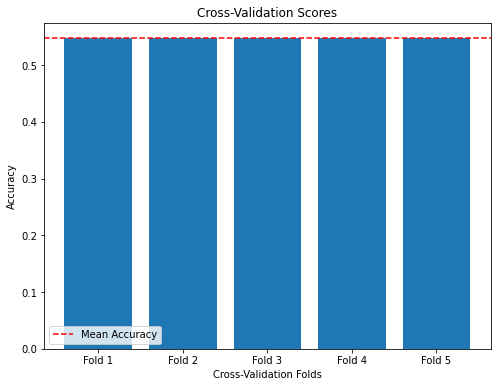

In [25]:
SESSION_FILE_PATH = "resources/session.csv"

df_sess = pd.read_csv(SESSION_FILE_PATH, delimiter='\t')

# Basic info
print(df_sess.info())

# Select features for training
selected_features = df_sess[['page_activity_duration', 'pct_rage_click', 'pct_scrandom']]

X = selected_features.copy()  # Create a copy to avoid "SettingWithCopyWarning"
y = df_sess['ack']            # 'ack' is target variable

numerical_features = ['page_activity_duration', 'pct_rage_click', 'pct_scrandom']

# Create an imputer for numerical features
numerical_imputer = SimpleImputer(strategy='mean')
X[numerical_features] = numerical_imputer.fit_transform(X[numerical_features])

# Standardize numerical features
scaler = StandardScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])

# Logistic regression model
model = LogisticRegression()

# Cross-validation
scores = cross_val_score(model, X, y, cv=5)  # 5-fold cross-validation

# Display score
print("Cross-Validation Scores:", scores)
print("Mean Accuracy:", scores.mean())
mean_accuracy = scores.mean()

# Bar plot
plt.figure(figsize=(8, 6))
plt.bar(range(len(scores)), scores, tick_label=['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5'])
plt.axhline(y=mean_accuracy, color='r', linestyle='--', label='Mean Accuracy')
plt.xlabel('Cross-Validation Folds')
plt.ylabel('Accuracy')
plt.title('Cross-Validation Scores')
plt.legend()
plt.show()

- Výsledky logistickej regresnej analýzy naznačujú, že pozorované údaje majú konzistentnú predikčnú presnosť na všetkých piatich cross validáciách.

- Pri cross validácii dosiahla naša logistická regresná analýza v priemere presnosť okolo 54,7 % na základe zadaných príznakov.

- Z týchto výsledkov vyplýva, že presnosť modelu závisí od vybraných príznakov a je možné zvýšiť presnosť tým, že pridaním alebo odstránením príznakov dosiahneme odlišné výsledky.

#### Sú niektoré atribúty medzi sebou závislé?
- Predpokladáme, že atribúty _page_activity_duration_ a _pct_rage_click_ sú medzi sebou závislé, dlhšia doba strávená na stráke môže znamenať nejasnosti ako dokončiť objednávku. Rovnako podľa nás existuje spojenie medzi _pct_scrandom_ a _pct_scroll_move_duration_.

- Rovnako predpokladáme, že premenná _ack_ bude závisieť od niektorých atribútov, ktoré súvisia s human-computer interaction. Zaradili by sme tu _pct_rage_click_, _pct_scrandom_. Ak niekto rage klikuje alebo scrolluje hore dole a nič mu nepríde zaujímavé, tak potom to bude mať priamy dôsledok na predikovanú premennú.

- Čo sa týka kombinovania záznamov zo všetkých troch .csv, tak určite si myslíme, že vieme vytvoriť zaujímavejšie modely a grafy. Nie je to nutnnosť, ale je to možnosť.

## Identifikácia problémov v dátach
- V daných datasetoch sme identifikovali niekoľko problémov:

        a) Chýbajúce dáta, napriklad pri pohlaví, dátume narodenia, zamestnaní
        b) Vychýlené dáta (outliers)
        c) Nejdnotný formát pri zamestnaní (niektoré zamestnania boli uvádzané v čínskych znakoch)
        d) Duplikaty


### Navrhnuté riešenia
- Častým problémom v dátach sú práve chýbajúce dáta, kedy v dátach nemáme konkrétnu očakávanú hodnotu, ale nešpecifovanú formu _NaN_. Pri analýze sa radšej snažíme chýbajúce dáta nahradiť nejakými dátami ako ich kompletne odstrániť. Napríklad pri chýbajúcich číselných dátach nahradzujeme priemerom, pri kategóriach alebo texte najčastejšie sa vyskytujúcou hodnotou.

- Najlepšie je predísť takýmto dátam zabezpečením systému, aby dané dáta nevznikli. Káždopádne, ako dátoví analytici sa s tým musíme popasovať.

In [26]:
"Kontrola duplicitnych zaznamov v df_pro"

duplikaty = df_pro.duplicated()

print(duplikaty.any())
print(df_pro[duplikaty])
df_pro.drop_duplicates(inplace=True)
print(df_pro.shape)

"Vypis:"

"False"
"Empty DataFrame"
"Columns: [location, product_ean, store_name, code]"
"Index: []"
"(14967, 4)"

"Zistil som že nie su duplicitné záznamy v df_pro"

duplikaty2 = df_usr.duplicated()

print(duplikaty2.any())
print(df_usr[duplikaty2])
df_usr.drop_duplicates(inplace=True)
print(df_usr.shape)

duplikaty3 = df_sess.duplicated()

print(duplikaty3.any())
print(df_sess[duplikaty3])
df_sess.drop_duplicates(inplace=True)
print(df_sess.shape)

"Vypis:"


"False"
"Empty DataFrame"
"Columns: [address, name, race, registration, username, current_location, sex, birthdate, mail, user_id, job]"
"Index: []"
"(2533, 11)"


"True"
"      browser_name  pct_input  ...  ack  pct_mouse_move"
"235          other    1.22833  ...  1.0        14.69446"
"624           edge    2.14493  ...  1.0        15.38634"
"655           edge    0.20995  ...  1.0         6.86017"
"1264        mobile    0.05148  ...  0.0         7.74393"
"1673       firefox    1.26327  ...  1.0        15.25390"
"...            ...        ...  ...  ...             ..."
"10881         edge    0.02443  ...  0.0        10.50255"
"10886       mobile    2.54048  ...  1.0        17.02484"
"10933         edge    0.19078  ...  1.0         5.82595"
"11066         edge    0.28929  ...  1.0         6.98133"
"11083         edge    0.03710  ...  0.0         9.64399"

"[132 rows x 25 columns]"
"(10967, 25)"

"Zisil som že ani v df_usr sa nenachádzajú duplikáty ale to však nemôžem povedať v df_sess"

"Po podrobnej analzye som usudil že sa nejedná o duplikáty, ktoré máme zmazať."
df_duplicates = df_sess[df_sess.duplicated(keep=False)]
print(df_duplicates)

False
Empty DataFrame
Columns: [location, product_ean, store_name, code]
Index: []
(14967, 4)
False
Empty DataFrame
Columns: [address, name, race, registration, username, current_location, sex, birthdate, mail, user_id, job]
Index: []
(2533, 11)
True
      browser_name  pct_input  wild_mouse_duration  pct_scroll_move_duration  \
235          other    1.22833             11.54997                  10.27058   
624           edge    2.14493             12.11425                   9.03906   
655           edge    0.20995              9.78135                  11.00141   
1264        mobile    0.05148              8.05470                  10.30574   
1673       firefox    1.26327             11.58207                   9.47875   
...            ...        ...                  ...                       ...   
10881         edge    0.02443              6.12460                  10.42372   
10886       mobile    2.54048             12.28346                   9.16954   
10933         edge    0.19078

In [27]:
## Overenie či nemáme chýbajúce hodnoty

print(df_pro.isnull().sum())

"Zistil som že nám chýbaju kódy v 22 obchodoch"

print(df_usr.isnull().sum())

"Zistil som že nám chýbaju dosť veľa rôzných hodnôt v jednotlivých stĺpcoch u rôzných používateľov"

print(df_sess.isnull().sum())

"Zistil som že nám chýba v niektorých stĺpcoch 11 údajov vo vybratých záznamov"

location        0
product_ean     0
store_name      0
code           22
dtype: int64
address              380
name                   0
race                   0
registration           0
username               0
current_location     127
sex                    0
birthdate           1140
mail                   0
user_id                0
job                 1520
dtype: int64
browser_name                       0
pct_input                         11
wild_mouse_duration               11
pct_scroll_move_duration          11
pct_wild_mouse                    11
session_start                      0
pct_doubleclick                   11
pct_rage_click                    11
pct_click                         11
page_activity_duration            11
product_ean                        0
pct_scrandom                      11
mouse_move_total_rel_distance     11
pct_click_product_info            11
scroll_move_total_rel_distance    11
session_id                         0
pct_mouse_click                   1

'Zistil som že nám chýba v niektorých stĺpcoch 11 údajov vo vybratých záznamov'

In [28]:
## Outliers

# funkcia na zistenie outliers staci poslat df_stlpec
def identify_outliers(x):
    lower = x.quantile(0.25) - 1.5 * iqr(x)   # porovnáva quartlies
    upper = x.quantile(0.75) + 1.5 * iqr(x)

    return x[(x > upper) | (x < lower)]

In [29]:
PRODUCT_FILE_PATH = "resources/product.csv"
USER_FILE_PATH = "resources/user.csv"
SESSION_FILE_PATH = "resources/session.csv"

# Read product, user, and session data into DataFrames
df_pro = pd.read_csv(PRODUCT_FILE_PATH, delimiter='\t')
df_usr = pd.read_csv(USER_FILE_PATH, delimiter='\t')
df_sess = pd.read_csv(SESSION_FILE_PATH, delimiter='\t')

outliers_pro_ean_usr = identify_outliers(df_pro["product_ean"])
print(outliers_pro_ean_usr)
# There are no outliers

outliers_sess_pad = identify_outliers(df_sess["page_activity_duration"])
print(outliers_sess_pad)
# There are no outliers

outliers_sess_rq = identify_outliers(df_sess["pct_rage_click"])
print(outliers_sess_rq)
# There are no outliers

outliers_sess_inp = identify_outliers(df_sess["pct_input"])
print(outliers_sess_inp)
# There are no outliers

# V daných stĺpcoch som outliers nenašiel.

Series([], Name: product_ean, dtype: int64)
Series([], Name: page_activity_duration, dtype: float64)
Series([], Name: pct_rage_click, dtype: float64)
Series([], Name: pct_input, dtype: float64)


## Formulácia a štatistické overenie hypotéz o dátach

### Hypotéza 1

- Daná hypotéza znie nasledovne:

  "_Zákazníci, ktorí si tovar nekúpia, hýbu počas sedenia myšou viac ako tí, ktorí si tovar kúpia._"

- Hypotéza _H0_ bude teda znieť nasledovne:
  
    "_Zákazníci, ktorí si tovar nekúpia, hýbu počas sedenia myšou rovnako ako tí, ktorí si tovar kúpia._"

- Správna alternatívna hypotéza _H1_ by pre tento prípad bola, že pohyb myšou je v oboch prípadoch rôzny, teda jedna skupina hýbe viac ako druhá, alebo naopak.


- Ako prvé si vytvoríme 2 datasety, ktoré rozdelíme podľa toho, či bol vykonaný nákup alebo nie. Nešpecifikované hodnoty vypustíme.

In [31]:
TESTED_ATTR = 'mouse_move_total_rel_distance'

no_ack_set = pd.DataFrame({'A': df_sess[df_sess['ack'] == 0][TESTED_ATTR]})
mean = no_ack_set.mean()
no_ack_set.fillna(mean, inplace=True)

ack_set = pd.DataFrame({'A': df_sess[df_sess['ack'] == 1][TESTED_ATTR]})
mean = ack_set.mean()
ack_set.fillna(mean, inplace=True)

- Teraz si pre porovnanie môžme pre oba prípady nakresliť dva grafy predstavujúce distribúcie dĺžiek pohybov myší.

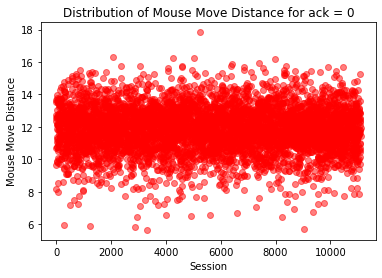

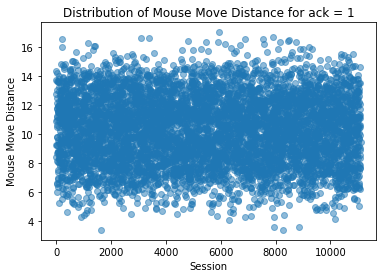

In [32]:
plt.scatter(x=no_ack_set.index, y=no_ack_set['A'], alpha=0.5, color='Red')
plt.xlabel("Session")
plt.ylabel("Mouse Move Distance")
plt.title("Distribution of Mouse Move Distance for ack = 0")
plt.show()

plt.scatter(x=ack_set.index, y=ack_set['A'], alpha=0.5)
plt.xlabel("Session")
plt.ylabel("Mouse Move Distance")
plt.title("Distribution of Mouse Move Distance for ack = 1")
plt.show()

- Z grafov už teraz vidno, že dané distribúce sú rozdielne, ale rovnako tak, že kupujúci hýbu viac myšou ako nekupujúci. To by teda nepotvrdzovalo našu hypotézu.
- Teraz môžme otestovať, či sú dané rozdelenia normálne.

In [33]:
def test_normality(df, ALPHA = 0.05):
    SHAPIRO_WILK_LIMIT = 5000
    p = -1
    
    if len(df) <= SHAPIRO_WILK_LIMIT:
        stat, p = stats.shapiro(df)
    else:
        stat, p = stats.kstest(df, 'norm')

    return p > ALPHA

def eval_dis_equality(p_val, ALPHA = 0.05):
    if p > ALPHA:
        print('Same distribution (fail to reject H0)')
        return True
    else:
        print('Different distribution (reject H0)')
        return False    


In [34]:
p = -1
if test_normality(ack_set) and test_normality(no_ack_set):
    t_stat, p = stats.ttest_ind(ack_set, no_ack_set)
elif not test_normality(ack_set) and not test_normality(no_ack_set):
    t_stat, p = mannwhitneyu(ack_set, no_ack_set)

- Výslednú p hodnotu vyhodnotíme tak, že ak je väčšia aka naša alpha hodnota, tak sú rozdelenie predsalen rovnaké, a teda platí hypotéza _H0_. V opačnom prípade sa podľa mediánu oboch rozdelení zistí, ktoré rozdelenie má priemerne väčšie hodnoty.
- Pre ešte lepší prehľad o výsledku použijeme v prípade rozdielnych rozdelení aj Box Plot graf na vizualizáciu mediánu.

Different distribution (reject H0)
The median of 'mouse_move_total_rel_distance' is greater for users with ack = 0 (no purchase).


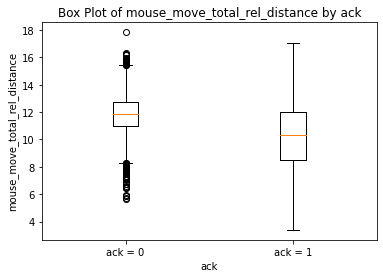

In [35]:
if not eval_dis_equality(p):

    median_no_ack = no_ack_set['A'].median()
    median_ack = ack_set['A'].median()
    
    if median_ack > median_no_ack:
        print(f"The median of '{TESTED_ATTR}' is greater for users with ack = 1 (item bought by user).")
    else:
        print(f"The median of '{TESTED_ATTR}' is greater for users with ack = 0 (no purchase).")

plt.boxplot([no_ack_set['A'], ack_set['A']], labels=['ack = 0', 'ack = 1'])
plt.xlabel('ack')
plt.ylabel(f"{TESTED_ATTR}")
plt.title(f"Box Plot of {TESTED_ATTR} by ack")
plt.show()


- Z výslednych hodnôt i grafu možno vidieť, že distribúcie sú rozdielne, takže _H1_ určite platí. Taktiež naša konkrétnejšia hypotéza bola v tomto prípade správna, nakoľko medián reprezentujúci dĺžku pohybu myši počas sedenia je predsalen väčší u nekupujúcich.

### Hypotéza 2

- V tejto časti testujeme nasledovnú hypotézu:

    _"Používatelia, ktorí si tovar kúpia, zadávajú viac vstupných dát ako tí, ktorí tovar nekúpia."_

- Hypotéza _H0_ bude teda znieť nasledovne:
  
    "_Zákazníci, ktorí si tovar nekúpia, vykonávajú rovnako veľa dvojitých klikov na myši ako tí, ktorí si tovar kúpia._"

- Správna alternatívna hypotéza _H1_ by pre tento prípad bola, že počet klikov je v oboch prípadoch rôzny, teda jedna skupina kliká viac dát ako druhá alebo naopak.

In [36]:
TESTED_ATTR = 'pct_doubleclick'

no_ack_set = pd.DataFrame({'A': df_sess[df_sess['ack'] == 0][TESTED_ATTR]})
mean = no_ack_set.mean()
no_ack_set.fillna(mean, inplace=True)

ack_set = pd.DataFrame({'A': df_sess[df_sess['ack'] == 1][TESTED_ATTR]})
mean = ack_set.mean()
ack_set.fillna(mean, inplace=True)

- Pre prehľadnosť si opäť zostrojíme distribučné grafy.

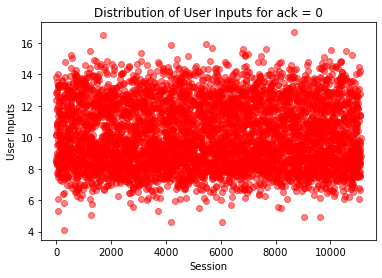

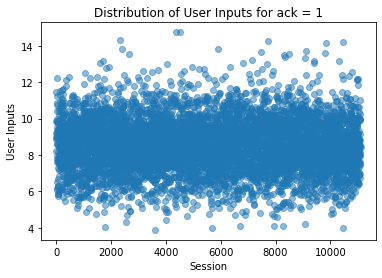

In [37]:
plt.scatter(x=no_ack_set.index, y=no_ack_set['A'], alpha=0.5, color='Red')
plt.xlabel("Session")
plt.ylabel("User Inputs")
plt.title("Distribution of User Inputs for ack = 0")
plt.show()

plt.scatter(x=ack_set.index, y=ack_set['A'], alpha=0.5)
plt.xlabel("Session")
plt.ylabel("User Inputs")
plt.title("Distribution of User Inputs for ack = 1")
plt.show()

- Z grafov možno vidieť, že distribúcie sú rôzne a že priemerne väčšie rozdelenie budú predstavovať nekupujúci používatelia. Teraz to môžme ísť dokázať tak, že najskôr otestujeme, či sú rozdelenia normálne.

In [38]:
p = -1
if test_normality(ack_set) and test_normality(no_ack_set):
    t_stat, p = stats.ttest_ind(ack_set, no_ack_set)
elif not test_normality(ack_set) and not test_normality(no_ack_set):
    t_stat, p = mannwhitneyu(ack_set, no_ack_set)

- Test na normalitu ukázal, že rozdelenia nie sú normálne, preto na zistenie ich rovnosti vykonáme __Mann-Whitney U test__.

Different distribution (reject H0)
The median of 'pct_doubleclick' is greater for users with ack = 0 (no purchase).


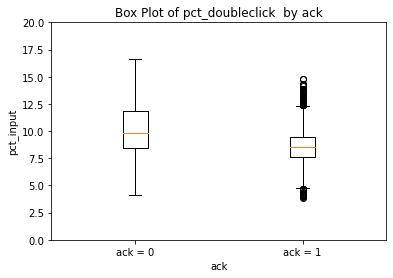

In [39]:
if not eval_dis_equality(p):

    # Compare the medians of the two groups
    median_no_ack = no_ack_set['A'].median()
    median_ack = ack_set['A'].median()
    
    if median_ack > median_no_ack:
        print(f"The median of '{TESTED_ATTR}' is greater for users with ack = 1 (item bought by user).")
    else:
        print(f"The median of '{TESTED_ATTR}' is greater for users with ack = 0 (no purchase).")

    plt.boxplot([no_ack_set['A'], ack_set['A']], labels=['ack = 0', 'ack = 1'])
    plt.xlabel('ack')
    plt.ylim(0, 20)
    plt.ylabel('pct_input')
    plt.title(f"Box Plot of {TESTED_ATTR}  by ack")
    plt.show()

- Z grafu aj z výpočtov vidno, že priemerný užívateľ, ktorý sa nákup nakoniec rozhodne nekúpiť, vykoná aj tak viac klikov ako ten, ktorý nákup kúpi. Týmito testami sme podložili našu hypotézu.

## Záverečné zhodnotenie Fazy 1

- _Analýza dát bola zaujímava a téma projektu nás tiež oslovila. Bude treba pridať kódy regiónov do product.csv na základe location manuálne. Z session.csv by sme vymazali alebo dali bokom 11 záznamov, ktoré nie su kompletné alebo doplnili ich pomocou medianu alebo inej stratégií. Outliers sa vyskytovali a pre tvorbu pekných vizuálnych grafov ich dáme v budúcnosti bokom a pošleme na analýzu aby sa posúdilo či nastala u nakupjúceho fatalný problem alebo len anomália v jeho činností. Zadanie hodnotíme pozitívne._